# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import eli5
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.impute import SimpleImputer
from prettytable import PrettyTable
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectKBest,chi2,mutual_info_classif,f_classif,RFE,SelectFromModel

# Algorithms
from sklearn.linear_model import LogisticRegression,RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC

In [2]:
%matplotlib inline
%precision 3
np.set_printoptions(precision=3)
np.random.seed(0)

In [3]:
def algo_eval(algo,gs,mdl,X_train, y_train, X_test,y_test):
    gs.fit(X_train, y_train)
    mdl.set_params(**gs.best_params_)
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)

    po   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['precision']
    ao   = accuracy_score(y_test, y_pred)
    ro   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['recall']
    f1o  = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['f1-score']
    r2o  = mdl.score(X_test, y_pred)
    auco = roc_auc_score(y_test, y_pred)
    mdl = None
    return [algo, ao,po,ro,f1o,r2o,auco]

# Import data

In [4]:
colnames=['Age','Work-Class','Fnlwgt','Education','Education_N','Marital_status','Ocupation','Relationship','Race','Sex','CapitalGain','CapitalLoss','HoursPerWeek','Country','Class'
]
data = pd.read_csv('data\incomedata.csv', header=None, names=colnames)
print('Shape of dataset:', data.shape)
data.head()

Shape of dataset: (32561, 15)


,Age,Work-Class,Fnlwgt,Education,Education_N,Marital_status,Ocupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,Country,Class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# General Observations:

In [5]:
# As Age increases, probability of income >50K increases.
# Work-Class "Private" has the major number of records.
# Education "Bachelors", "HS_Grad", "Masters", "Some College" have the highest ratio of income >50K
# "Married-civ-spouse" has the highest ratio income ?50KK
# "Exec-Managerial", "Prof-specialty" occupation have the highest ratio for income >50K
# "Husband" relationship has the highest ratio for income >50K
# "White" race and "Male" have the highest ratio of income >50K
# Majority of the people work 38 hours a week. 
# 7841 records have income >50K and 24720 records have income <50K


# Clean data

In [6]:
# Replace ? with NAN
data.replace('?', np.nan, inplace=True)

In [7]:
# Remove Education_N & Final Weight
data.drop("Education_N", inplace=True, axis=1)
data.drop("Fnlwgt", inplace=True, axis=1)
data.head()

,Age,Work-Class,Education,Marital_status,Ocupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,Country,Class
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Seperate Categorical and Continuous data

In [8]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
Age               32561 non-null int64
Work-Class        32561 non-null object
Education         32561 non-null object
Marital_status    32561 non-null object
Ocupation         32561 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null object
CapitalGain       32561 non-null int64
CapitalLoss       32561 non-null int64
HoursPerWeek      32561 non-null int64
Country           32561 non-null object
Class             32561 non-null object
dtypes: int64(4), object(9)
memory usage: 3.2+ MB
None


In [9]:
cat_feature_mask = (data.dtypes==object)
cat_cols = data.columns[cat_feature_mask].tolist()

data_cat = data[cat_cols]
data_cat.head()

,Work-Class,Education,Marital_status,Ocupation,Relationship,Race,Sex,Country,Class
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


In [10]:
num_feature_mask = (data.dtypes!=object)
num_cols = data.columns[num_feature_mask].tolist()

data_num = data[num_cols]
data_num.head()

,Age,CapitalGain,CapitalLoss,HoursPerWeek
0,39,2174,0,40
1,50,0,0,13
2,38,0,0,40
3,53,0,0,40
4,28,0,0,40


# Exploratory Analysis:

In [11]:
data_num.shape

(32561, 4)

In [12]:
data_num.isnull().sum()

Age             0
CapitalGain     0
CapitalLoss     0
HoursPerWeek    0
dtype: int64

In [13]:
data_num.fillna(data_num.mean())

,Age,CapitalGain,CapitalLoss,HoursPerWeek
0,39,2174,0,40
1,50,0,0,13
2,38,0,0,40
3,53,0,0,40
4,28,0,0,40
...,...,...,...,...
32556,27,0,0,38
32557,40,0,0,40
32558,58,0,0,40
32559,22,0,0,20


In [14]:
data_num.describe()

,Age,CapitalGain,CapitalLoss,HoursPerWeek
count,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1077.648844,87.303830,40.437456
std,13.640433,7385.292085,402.960219,12.347429
min,17.000000,0.000000,0.000000,1.000000
25%,28.000000,0.000000,0.000000,40.000000
50%,37.000000,0.000000,0.000000,40.000000
75%,48.000000,0.000000,0.000000,45.000000
max,90.000000,99999.000000,4356.000000,99.000000


In [15]:
# Correlation:
corr = data_num.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Age,CapitalGain,CapitalLoss,HoursPerWeek
Age,1,0.078,0.058,0.069
CapitalGain,0.078,1,-0.032,0.078
CapitalLoss,0.058,-0.032,1,0.054
HoursPerWeek,0.069,0.078,0.054,1


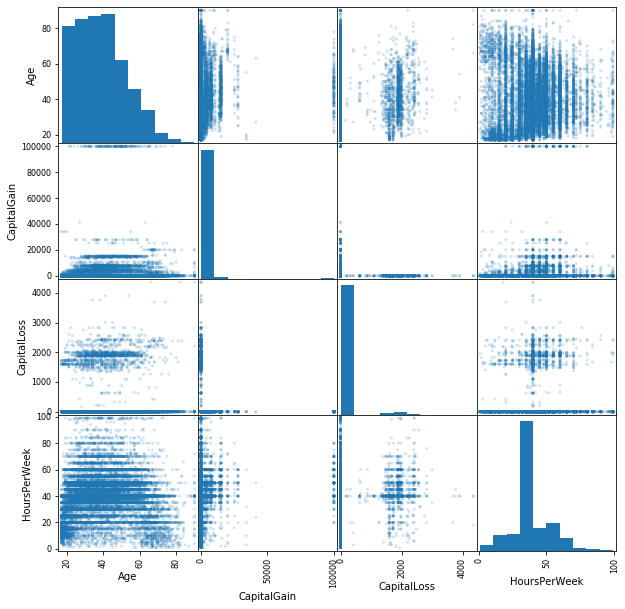

In [16]:
# Scatter Matrix
pd.plotting.scatter_matrix(data_num, alpha=0.2, figsize=(10, 10))
plt.show()

In [17]:
# OUTLIERS
Q1 = data_num.quantile(0.25)
Q3 = data_num.quantile(0.75)
IQR = Q3 - Q1
  
print('Before Outliers check, Row count is: ',len(data_num.index))
df_o_n = data_num[~((data_num < (Q1 - 1.5 * IQR)) |(data_num > (Q3 + 1.5 * IQR))).any(axis=1)]
print('After Outliers are removed, Row count is: ',len(data_num.index)) 

Before Outliers check, Row count is:  32561
After Outliers are removed, Row count is:  32561


In [18]:
# Join Categorical and Numerical data
data_nc = data_num.join(data_cat)
data_nc.head()

,Age,CapitalGain,CapitalLoss,HoursPerWeek,Work-Class,Education,Marital_status,Ocupation,Relationship,Race,Sex,Country,Class
0,39,2174,0,40,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,50,0,0,13,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,38,0,0,40,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,53,0,0,40,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,28,0,0,40,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


# Feature Selection

In [19]:
# PCA Analysis to see how many features could be kept :
y = data_nc['Class']
X = data_nc.drop('Class', axis=1)

# le = LabelEncoder()
# le.fit(y)
# y_enc = le.transform(y)
# X_enc = pd.get_dummies(X, prefix_sep='_', drop_first=True)

encoder = ce.OneHotEncoder()
encoder.fit(X, y)
X_o = encoder.transform(X)
X_covariance_matrix = np.cov(X_o.T)
# X_covariance_matrix = np.cov(X_enc.T)

eig_vals, eig_vecs = np.linalg.eig(X_covariance_matrix)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)     
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print ("Variance captured by each component is \n",var_exp[:5])
print(40 * '-')
print ("Cumulative variance captured as we travel each component \n",cum_var_exp[:5])

Variance captured by each component is 
 [(99.70285286954378+0j), (0.29652602808865197+0j), (0.00034222100306176674+0j), (0.0002710914827943044+0j), (1.3356795195597474e-06+0j)]
----------------------------------------
Cumulative variance captured as we travel each component 
 [ 99.703+0.j  99.999+0.j 100.   +0.j 100.   +0.j 100.   +0.j]


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_o, y, stratify=y, test_size=.3, random_state=42)

In [21]:
# Chi Squared test
sel_chi2 = SelectKBest(chi2, k=4)
X_train_chi2 = sel_chi2.fit_transform(X_train, y_train)
print(sel_chi2.get_support())

[ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False]


In [63]:
# mask = sel_chi2.get_support()

# cols = sel_chi2.get_support(indices=True)
# print(cols)
# features_df_new = X_train[cols]
# print(features_df_new)

AttributeError: 'SelectKBest' object has no attribute 'columns'

In [61]:
# new_features = X_train.columns[mask]
# print(new_features)

In [22]:
# ANOVA test
sel_f = SelectKBest(f_classif, k=4)
X_train_f = sel_f.fit_transform(X_train, y_train)
print(sel_f.get_support())

[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True  True False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False]


In [23]:
# Mutual Info ClassIF test
sel_mutual = SelectKBest(mutual_info_classif, k=4)
X_train_mutual = sel_mutual.fit_transform(X_train, y_train)
print(sel_mutual.get_support())

[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False]


In [24]:
# Logistic Regression as the Model
model_logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
sel_rfe_logistic = RFE(estimator=model_logistic, n_features_to_select=4, step=1)
X_train_rfe_logistic = sel_rfe_logistic.fit_transform(X_train, y_train)
print(sel_rfe_logistic.get_support())

C:\Users\I054497\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\I054497\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\I054497\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\I054497\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\I054497\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_mode

[False False False False False False False False False False False False
 False False False False False False False False False False  True  True
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False]


In [25]:
# Random Forest as the Model
model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
sel_rfe_tree = RFE(estimator=model_tree, n_features_to_select=4, step=1)
X_train_rfe_tree = sel_rfe_tree.fit_transform(X_train, y_train)
print(sel_rfe_tree.get_support())

[ True  True False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False]


In [26]:
# L1-based feature selection
model_logistic = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10000, penalty='l1')
sel_model_logistic = SelectFromModel(estimator=model_logistic)
X_train_sfm_l1 = sel_model_logistic.fit_transform(X_train, y_train)
print(sel_model_logistic.get_support())

[ True  True  True  True False False  True False False  True  True False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True False False  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True False  True
 False False False  True  True  True  True  True  True  True  True False
 False False  True  True  True False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False]


In [27]:
# Tree-based feature selection
model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
model_tree.fit(X_train, y_train)
print(model_tree.feature_importances_)
sel_model_tree = SelectFromModel(estimator=model_tree, prefit=True, threshold='mean')  
# since we already fit the data, we specify prefit option here
# Features whose importance is greater or equal to the threshold are kept while the others are discarded.
X_train_sfm_tree = sel_model_tree.transform(X_train)
print(sel_model_tree.get_support())

[2.243e-01 1.102e-01 3.412e-02 1.142e-01 5.561e-03 9.410e-03 1.280e-02
 5.661e-03 6.839e-03 2.000e-03 7.480e-03 8.171e-05 1.042e-05 2.504e-02
 1.330e-02 3.696e-03 1.373e-02 2.411e-03 1.065e-02 5.206e-03 5.883e-03
 4.093e-03 7.018e-03 7.922e-03 1.441e-03 3.712e-03 5.154e-04 1.425e-04
 1.747e-03 1.784e-02 5.429e-02 7.365e-03 1.191e-03 2.196e-03 4.176e-04
 1.934e-03 5.814e-03 2.343e-02 3.829e-03 2.390e-02 6.520e-03 7.395e-03
 7.382e-03 4.817e-03 4.790e-03 4.496e-03 5.232e-03 1.813e-03 3.955e-03
 3.045e-05 1.877e-04 1.031e-02 6.700e-02 1.086e-02 8.892e-03 4.588e-03
 1.679e-03 7.272e-03 5.870e-03 3.601e-03 1.466e-03 1.098e-03 8.329e-03
 1.151e-02 7.364e-03 6.464e-04 5.404e-04 1.162e-03 2.888e-03 3.092e-03
 6.760e-04 6.458e-04 2.972e-06 8.928e-04 1.382e-03 1.352e-03 3.656e-04
 1.137e-03 7.377e-04 6.369e-04 2.748e-04 4.316e-04 6.930e-05 1.481e-04
 1.182e-04 4.460e-04 2.154e-04 2.096e-04 1.633e-04 3.255e-04 3.772e-04
 9.788e-05 5.899e-04 4.462e-04 3.024e-04 1.118e-04 2.284e-05 6.741e-05
 1.550

# Inferential Statistics

In [28]:
y = data_nc['Class']
X = data_nc.drop('Class', axis=1)

le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

In [30]:
cat_feature_mask = (X_train.dtypes==object)
cat_cols = X_train.columns[cat_feature_mask].tolist()
num_feature_mask = (X_train.dtypes!=object)
num_cols = X_train.columns[num_feature_mask].tolist()

In [31]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(copy=False))])

preprocessor = ColumnTransformer([
    ("numerical", numeric_transformer, num_cols),
    ("categorical", categorical_transformer, cat_cols)])

# Logistic Regression
lr_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42))])

# Decision Tree
dt_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", DecisionTreeClassifier(class_weight="balanced"))])

# Random Forest
rf_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", RandomForestClassifier(class_weight="balanced", n_estimators=100, n_jobs=-1))])

# SVM
svm_model = Pipeline([("preprocessor", preprocessor), 
                      ("model", SVC(kernel='linear', C = 1.0))])

# XGBoost
xgb_model = Pipeline([("preprocessor", preprocessor), 
                      ("model", XGBClassifier(scale_pos_weight=(1 - y_train.mean()), n_jobs=-1))])

# RidgeCV
rdgcv_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", RidgeClassifierCV())])

# HistGradientBoostingRegressor
hgbr_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", HistGradientBoostingClassifier())])

In [32]:
pt = PrettyTable(["Algorithm", "Accuracy", "Precision", "Recall", "F1 Score", "R2", "AUC Score"], sortby="AUC Score",reversesort=True)

In [33]:
pt.clear_rows()
print(pt)

+-----------+----------+-----------+--------+----------+----+-----------+
| Algorithm | Accuracy | Precision | Recall | F1 Score | R2 | AUC Score |
+-----------+----------+-----------+--------+----------+----+-----------+
+-----------+----------+-----------+--------+----------+----+-----------+


# Logistic Regression:

In [34]:
n_components = []

params_grid = [{
"model__C": [1, 1.3, 1.5]
}]

gs = GridSearchCV(lr_model, param_grid = params_grid, n_jobs=-1, cv=10, refit='AUC', scoring='roc_auc',iid=True)
# gs.fit(X_train, y_train)
# lr_model.set_params(**gs.best_params_)
# lr_model.fit(X_train, y_train)
# y_pred = lr_model.predict(X_test)

# po   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['precision']
# ao   = accuracy_score(y_test, y_pred)
# ro   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['recall']
# f1o  = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['f1-score']
# r2o  = lr_model.score(X_test, y_pred)
# auco = roc_auc_score(y_test, y_pred)

# pt.add_row(["LogReg", "%.2f" % ao, "%.2f" % po, "%.2f" % ro, "%.2f" % f1o, "%.2f" % r2o, "%.2f" % auco])

In [35]:
algo, ao, po, ro, f1o, r2o, auco = algo_eval('LogReg2',gs,lr_model,X_train, y_train, X_test,y_test)
pt.add_row([algo, "%.2f" % ao, "%.2f" % po, "%.2f" % ro, "%.2f" % f1o, "%.2f" % r2o, "%.2f" % auco])

# Decision Tree

In [36]:
gs = GridSearchCV(dt_model, {"model__max_depth": [3, 5, 7],"model__min_samples_split": [2, 5]},n_jobs=-1, cv=5, refit='AUC', scoring='roc_auc',iid=True)
# gs.fit(X_train, y_train)
# dt_model.set_params(**gs.best_params_)
# dt_model.fit(X_train, y_train)
# y_pred = dt_model.predict(X_test)

# po   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['precision']
# ao   = accuracy_score(y_test, y_pred)
# ro   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['recall']
# f1o  = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['f1-score']
# r2o  = dt_model.score(X_test, y_pred)
# auco = roc_auc_score(y_test, y_pred)

# pt.add_row(["DecisionTree", "%.2f" % ao, "%.2f" % po, "%.2f" % ro, "%.2f" % f1o, "%.2f" % r2o, "%.2f" % auco])

In [37]:
algo, ao, po, ro, f1o, r2o, auco = algo_eval('DecisionTree2',gs,dt_model,X_train, y_train, X_test,y_test)
pt.add_row([algo, "%.2f" % ao, "%.2f" % po, "%.2f" % ro, "%.2f" % f1o, "%.2f" % r2o, "%.2f" % auco])

# Random Forest

In [38]:
gs = GridSearchCV(rf_model, {"model__max_depth": [10, 15],"model__min_samples_split": [5, 10]},n_jobs=-1, cv=5, refit='AUC', scoring='roc_auc',iid=True)
# gs.fit(X_train, y_train)
# rf_model.set_params(**gs.best_params_)
# rf_model.fit(X_train, y_train)
# y_pred = rf_model.predict(X_test)

# po   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['precision']
# ao   = accuracy_score(y_test, y_pred)
# ro   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['recall']
# f1o  = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['f1-score']
# r2o  = rf_model.score(X_test, y_pred)
# auco = roc_auc_score(y_test, y_pred)

# pt.add_row(["RandomForest", "%.2f" % ao, "%.2f" % po, "%.2f" % ro, "%.2f" % f1o, "%.2f" % r2o, "%.2f" % auco])

In [39]:
algo, ao, po, ro, f1o, r2o, auco = algo_eval('RandomForest2',gs,rf_model,X_train, y_train, X_test,y_test)
pt.add_row([algo, "%.2f" % ao, "%.2f" % po, "%.2f" % ro, "%.2f" % f1o, "%.2f" % r2o, "%.2f" % auco])

# XGBoost

In [40]:
gs_o = GridSearchCV(xgb_model, {"model__max_depth": [5, 10],"model__min_child_weight": [5, 10],"model__n_estimators": [25]},
                  n_jobs=-1, cv=5, refit='AUC', scoring='roc_auc',iid=True)
# gs.fit(X_train, y_train)
# xgb_model.set_params(**gs.best_params_)
# xgb_model.fit(X_train, y_train)
# y_pred = xgb_model.predict(X_test)

# po   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['precision']
# ao   = accuracy_score(y_test, y_pred)
# ro   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['recall']
# f1o  = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['f1-score']
# r2o  = xgb_model.score(X_test, y_pred)
# auco = roc_auc_score(y_test, y_pred)

# pt.add_row(["XGBoost", "%.2f" % ao, "%.2f" % po, "%.2f" % ro, "%.2f" % f1o, "%.2f" % r2o, "%.2f" % auco])

In [41]:
algo, ao, po, ro, f1o, r2o, auco = algo_eval('XGBoost2',gs,xgb_model,X_train, y_train, X_test,y_test)
pt.add_row([algo, "%.2f" % ao, "%.2f" % po, "%.2f" % ro, "%.2f" % f1o, "%.2f" % r2o, "%.2f" % auco])

# SVM

In [42]:
# gs = GridSearchCV(svm_model, param_grid = params_grid,n_jobs=-1, cv=5, refit='AUC', scoring='roc_auc',iid=True)
# gs.fit(X_train, y_train)
# svm_model.set_params(**gs.best_params_)
# svm_model.fit(X_train, y_train)
# y_pred = svm_model.predict(X_test)

# po   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['precision']
# ao   = accuracy_score(y_test, y_pred)
# ro   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['recall']
# f1o  = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['f1-score']
# r2o  = svm_model.score(X_test, y_pred)
# auco = roc_auc_score(y_test, y_pred)

# pt.add_row(["SVM", "%.2f" % ao, "%.2f" % po, "%.2f" % ro, "%.2f" % f1o, "%.2f" % r2o, "%.2f" % auco])

# RidgeClassifierCV

In [43]:
rdgcv_model.fit(X_train, y_train)
y_pred = rdgcv_model.predict(X_test)

po   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['precision']
ao   = accuracy_score(y_test, y_pred)
ro   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['recall']
f1o  = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['f1-score']
r2o  = rdgcv_model.score(X_test, y_pred)
auco = roc_auc_score(y_test, y_pred)

pt.add_row(["RidgeCV", "%.2f" % ao, "%.2f" % po, "%.2f" % ro, "%.2f" % f1o, "%.2f" % r2o, "%.2f" % auco])

# HistGradientBoostingRegressor

In [44]:
hgbr_model.fit(X_train, y_train)
y_pred = hgbr_model.predict(X_test)

po   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['precision']
ao   = accuracy_score(y_test, y_pred)
ro   = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['recall']
f1o  = classification_report(y_test, y_pred,output_dict=True)['weighted avg']['f1-score']
r2o  = hgbr_model.score(X_test, y_pred)
auco = roc_auc_score(y_test, y_pred)

pt.add_row(["HistGradientBoost", "%.2f" % ao, "%.2f" % po, "%.2f" % ro, "%.2f" % f1o, "%.2f" % r2o, "%.2f" % auco])

# Models Comparison Table:

In [45]:
print(pt)

+-------------------+----------+-----------+--------+----------+------+-----------+
|     Algorithm     | Accuracy | Precision | Recall | F1 Score |  R2  | AUC Score |
+-------------------+----------+-----------+--------+----------+------+-----------+
|   RandomForest2   |   0.81   |    0.86   |  0.81  |   0.82   | 1.00 |    0.83   |
|      LogReg2      |   0.81   |    0.85   |  0.81  |   0.82   | 1.00 |    0.82   |
| HistGradientBoost |   0.88   |    0.87   |  0.88  |   0.87   | 1.00 |    0.80   |
|   DecisionTree2   |   0.75   |    0.84   |  0.75  |   0.77   | 1.00 |    0.80   |
|      XGBoost2     |   0.87   |    0.86   |  0.87  |   0.86   | 1.00 |    0.78   |
|      RidgeCV      |   0.84   |    0.83   |  0.84  |   0.83   | 1.00 |    0.73   |
+-------------------+----------+-----------+--------+----------+------+-----------+


# Best Model selected:

In [46]:
lr_bestmodel = lr_model

In [47]:
# Refit Best Model and Predict:
lr_bestmodel.fit(X_train, y_train)
y_pred = lr_bestmodel.predict(X_test)
print('Best Model ROC_AUC:',roc_auc_score(y_test, y_pred))

Best Model ROC_AUC: 0.8245796565896144


In [48]:
# Download the results:
res = pd.DataFrame(y_pred)
res.index = X_test.index
res.columns = ["prediction"]
df = X_test.join(res)
# X_test.to_csv("data\prediction_input.csv")
# res.to_csv("data\prediction_results.csv")
df.to_csv("data\mergedprediction_results.csv")

# Explain Predictions: 

In [49]:
preprocessor = lr_bestmodel.named_steps["preprocessor"]
ohe_categories = preprocessor.named_transformers_["categorical"]["onehot"].categories_
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_cols, ohe_categories) for val in vals]
all_features = num_cols + new_ohe_features
eli5.show_weights(lr_bestmodel.named_steps["model"], feature_names=all_features, top=20)

In [50]:
# Convert to Dataframe
eli5_df = eli5.explain_weights_df(lr_bestmodel.named_steps["model"], feature_names=all_features, top=20)
eli5_df['weight'] = eli5_df['weight'] * 100
eli5_df

,target,feature,weight
0,1,CapitalGain,233.481527
1,1,Education__ Doctorate,211.450893
2,1,Education__ Prof-school,194.846439
3,1,Marital_status__ Married-civ-spouse,147.269885
4,1,Education__ Masters,136.206715
5,1,Relationship__ Wife,115.715301
6,1,Marital_status__ Married-AF-spouse,114.567345
7,1,Country__ Cambodia,111.589503
8,1,Education__ Bachelors,107.204818
9,1,Relationship__ Own-child,-106.709241


In [51]:
# Row 4 details:
i=4
eli5.explain_prediction_df(lr_bestmodel.named_steps["model"], 
                     lr_bestmodel.named_steps["preprocessor"].transform(X_test)[i],
                     feature_names=all_features)

,target,feature,weight,value
0,1,Marital_status__ Married-civ-spouse,1.472699,1.000000
1,1,Education__ Bachelors,1.072048,1.000000
2,1,HoursPerWeek,0.651175,1.572934
3,1,Ocupation__ Sales,0.362766,1.000000
4,1,Country__ United-States,0.332243,1.000000
5,1,Age,0.101275,0.250635
6,1,Work-Class__ Private,0.094294,1.000000
7,1,Race__ White,-0.006781,1.000000
8,1,CapitalLoss,-0.052696,-0.215155
9,1,Sex__ Male,-0.124523,1.000000
